<a href="https://colab.research.google.com/github/jihyeon602/DeepLearning_practice/blob/main/DACON_artist_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 22 11:01:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# 데이콘 아티스트 분류

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import zipfile

zip_file_path = '/content/drive/MyDrive/Classroom/open.zip'
extract_to = '/content/drive/MyDrive/artist'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("압축 해제 완료!")

압축 해제 완료!


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/artist/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/artist/test.csv')

In [7]:
print(train_df.info())
print(train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5911 entries, 0 to 5910
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5911 non-null   int64 
 1   img_path  5911 non-null   object
 2   artist    5911 non-null   object
dtypes: int64(1), object(2)
memory usage: 138.7+ KB
None
   id          img_path            artist
0   0  ./train/0000.jpg   Diego Velazquez
1   1  ./train/0001.jpg  Vincent van Gogh
2   2  ./train/0002.jpg      Claude Monet
3   3  ./train/0003.jpg       Edgar Degas
4   4  ./train/0004.jpg  Hieronymus Bosch


In [ ]:
print(test_df.info())
print(test_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12670 entries, 0 to 12669
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        12670 non-null  object
 1   img_path  12670 non-null  object
dtypes: object(2)
memory usage: 198.1+ KB
None
           id               img_path
0  TEST_00000  ./test/TEST_00000.jpg
1  TEST_00001  ./test/TEST_00001.jpg
2  TEST_00002  ./test/TEST_00002.jpg
3  TEST_00003  ./test/TEST_00003.jpg
4  TEST_00004  ./test/TEST_00004.jpg


In [10]:
print(train_df.artist.unique())
print(len(train_df.artist.unique()))

['Diego Velazquez' 'Vincent van Gogh' 'Claude Monet' 'Edgar Degas'
 'Hieronymus Bosch' 'Pierre-Auguste Renoir' 'Rene Magritte' 'Michelangelo'
 'Peter Paul Rubens' 'Caravaggio' 'Alfred Sisley' 'Edouard Manet'
 'Rembrandt' 'Francisco Goya' 'Pablo Picasso' 'Titian' 'Mikhail Vrubel'
 'Leonardo da Vinci' 'Kazimir Malevich' 'Andy Warhol' 'Vasiliy Kandinskiy'
 'Gustav Klimt' 'Amedeo Modigliani' 'Henri Rousseau' 'Salvador Dali'
 'Pieter Bruegel' 'Albrecht Du rer' 'Paul Gauguin' 'Sandro Botticelli'
 'Piet Mondrian' 'Eugene Delacroix' 'Paul Klee' 'William Turner'
 'Marc Chagall' 'Jan van Eyck' 'Henri Matisse' 'El Greco'
 'Gustave Courbet' 'Andrei Rublev' 'Jackson Pollock' 'Edvard Munch'
 'Camille Pissarro' 'Raphael' 'Henri de Toulouse-Lautrec' 'Joan Miro'
 'Giotto di Bondone' 'Diego Rivera' 'Frida Kahlo' 'Georges Seurat'
 'Paul Cezanne']
50


- 50명의 아티스트


In [8]:
train_df['artist'] = train_df['artist'].str.replace(" ", "_")
train_df['artist'] = train_df['artist'].str.replace("-", "_")


In [9]:
train_df['artist'].unique()

array(['Diego_Velazquez', 'Vincent_van_Gogh', 'Claude_Monet',
       'Edgar_Degas', 'Hieronymus_Bosch', 'Pierre_Auguste_Renoir',
       'Rene_Magritte', 'Michelangelo', 'Peter_Paul_Rubens', 'Caravaggio',
       'Alfred_Sisley', 'Edouard_Manet', 'Rembrandt', 'Francisco_Goya',
       'Pablo_Picasso', 'Titian', 'Mikhail_Vrubel', 'Leonardo_da_Vinci',
       'Kazimir_Malevich', 'Andy_Warhol', 'Vasiliy_Kandinskiy',
       'Gustav_Klimt', 'Amedeo_Modigliani', 'Henri_Rousseau',
       'Salvador_Dali', 'Pieter_Bruegel', 'Albrecht_Du_rer',
       'Paul_Gauguin', 'Sandro_Botticelli', 'Piet_Mondrian',
       'Eugene_Delacroix', 'Paul_Klee', 'William_Turner', 'Marc_Chagall',
       'Jan_van_Eyck', 'Henri_Matisse', 'El_Greco', 'Gustave_Courbet',
       'Andrei_Rublev', 'Jackson_Pollock', 'Edvard_Munch',
       'Camille_Pissarro', 'Raphael', 'Henri_de_Toulouse_Lautrec',
       'Joan_Miro', 'Giotto_di_Bondone', 'Diego_Rivera', 'Frida_Kahlo',
       'Georges_Seurat', 'Paul_Cezanne'], dtype=object)

In [ ]:
import shutil


# 이미지 폴더 경로
train_img = '/content/content/drive/MyDrive/artist/train'  # 이미지 파일들이 위치한 폴더

# 아티스트별 폴더가 저장될 디렉토리 경로
target_folder = '/content/content/drive/MyDrive/artist/train'

# 50개의 아티스트 별로 폴더 생성 (중복된 artist명을 기준으로)
artists = train_df['artist'].unique()

# 각 아티스트별 폴더 생성
for artist in artists:
    artist_folder = os.path.join(target_folder, artist)
    os.makedirs(artist_folder, exist_ok=True)

# 이미지 파일을 아티스트 폴더로 이동
for _, row in train_df.iterrows():
    img_id = row['id']
    img_path = row['img_path']
    artist = row['artist']

    # 이미지 파일 경로 (train 폴더 내에서 이미지가 위치한 경로)
    img_path_corrected = img_path.replace('./train/', '')
    img_file = os.path.join(train_img, img_path_corrected)

    # 아티스트별 폴더로 파일 이동
    if os.path.exists(img_file):
        target_path = os.path.join(target_folder, artist, f"{img_id}.jpg")
        shutil.move(img_file, target_path)
    else:
        print(f"File {img_file} does not exist!")

File /content/content/drive/MyDrive/artist/train/3896.jpg does not exist!


In [ ]:
'''
# 0001.jpg부터 5902.jpg까지 삭제
for i in range(1, 5911):
    file_name = f"{i:04d}.jpg"  # 0001.jpg, 0002.jpg, ..., 5902.jpg 형식으로 만듦
    img_file = os.path.join(train_img, file_name)  # 경로에 파일 이름 추가

    # 파일이 존재하면 삭제
    if os.path.exists(img_file):
        os.remove(img_file)
        print(f"Deleted {img_file}")
    else:
        print(f"File {img_file} does not exist.")'''

<ipython-input-11-ef497c117a90>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(train_counts.index, fontfamily='serif', rotation=80)


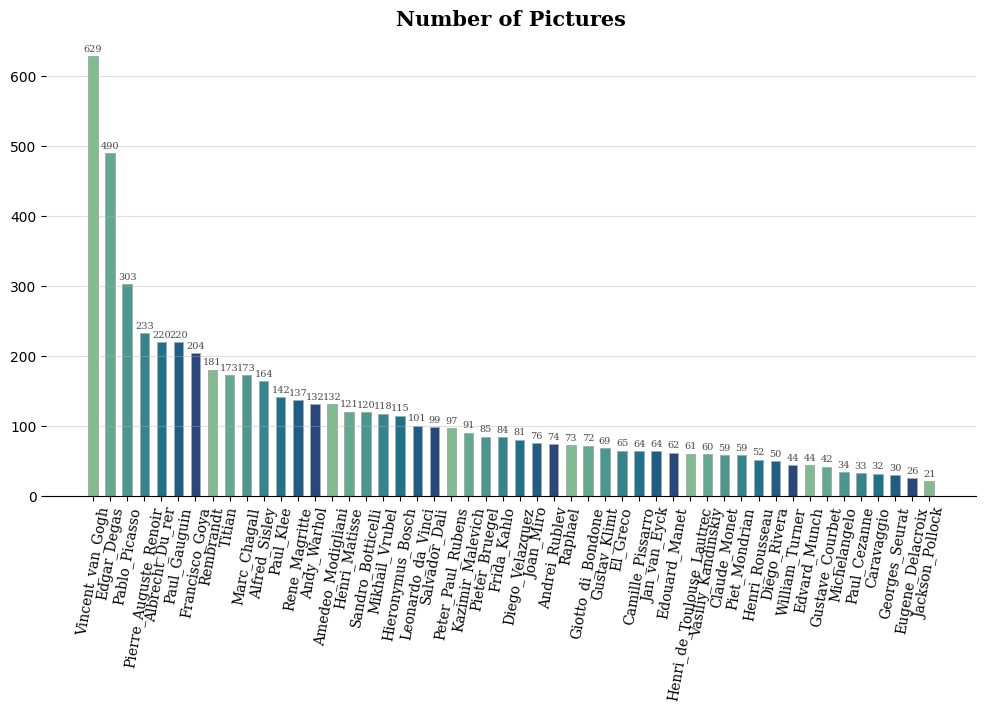

In [ ]:
import seaborn as sns

train_counts=train_df['artist'].value_counts()

ig,ax=plt.subplots(1,1,figsize=(12,6))
ax.bar(train_counts.index, train_counts, width=0.55,
       edgecolor='darkgray',color=sns.color_palette('crest',7),
        linewidth=0.7
       )

for artist in train_counts.index:
  ax.annotate(f'{train_counts[artist]}',
              xy=(artist, train_counts[artist]+10),
              va='center', ha='center', fontweight='light', fontfamily='serif',
              fontsize=7,color='#4a4a4a'
              )

for s in ['top','left','right']:
  ax.spines[s].set_visible(False)

ax.set_xticklabels(train_counts.index, fontfamily='serif', rotation=80)
plt.title('Number of Pictures', fontsize=15, fontweight='bold', fontfamily='serif')
ax.grid(axis='y', linestyle='-', alpha=0.4)
plt.show()

In [ ]:
train_counts

,count
artist,
Vincent_van_Gogh,629
Edgar_Degas,490
Pablo_Picasso,303
Pierre_Auguste_Renoir,233
Albrecht_Du_rer,220
Paul_Gauguin,220
Francisco_Goya,204
Rembrandt,181
Titian,173


- 반고흐의 그림이 압도적으로 많음
- 그림을 세기/장르에 따라도 분류해보겠음

In [ ]:
artist_info = pd.read_csv('/content/content/drive/MyDrive/artist/artists_info.csv')
print(artist_info.info())
print(artist_info.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         50 non-null     object
 1   years        50 non-null     object
 2   genre        50 non-null     object
 3   nationality  50 non-null     object
dtypes: object(4)
memory usage: 1.7+ KB
None
                 name        years                         genre nationality
0   Amedeo Modigliani  1884 - 1920                 Expressionism     Italian
1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism     Russian
2        Diego Rivera  1886 - 1957       Social Realism,Muralism     Mexican
3        Claude Monet  1840 - 1926                 Impressionism      French
4       Rene Magritte  1898 - 1967      Surrealism,Impressionism     Belgian


In [ ]:
artist_info.genre.unique()

array(['Expressionism', 'Expressionism,Abstractionism',
       'Social Realism,Muralism', 'Impressionism',
       'Surrealism,Impressionism', 'Surrealism', 'Realism,Impressionism',
       'Byzantine Art', 'Post-Impressionism', 'Symbolism,Art Nouveau',
       'Northern Renaissance', 'Suprematism', 'Symbolism', 'Cubism',
       'Baroque', 'Romanticism', 'Primitivism,Surrealism', 'Mannerism',
       'Primitivism', 'Proto Renaissance', 'Early Renaissance',
       'High Renaissance', 'Impressionism,Post-Impressionism',
       'High Renaissance,Mannerism', 'Realism', 'Symbolism,Expressionism',
       'Expressionism,Abstractionism,Surrealism', 'Neoplasticism',
       'Pop Art', 'Symbolism,Post-Impressionism',
       'Abstract Expressionism'], dtype=object)

<ipython-input-15-313f1c59cbce>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(genre_counts.index, fontfamily='serif', rotation=80)


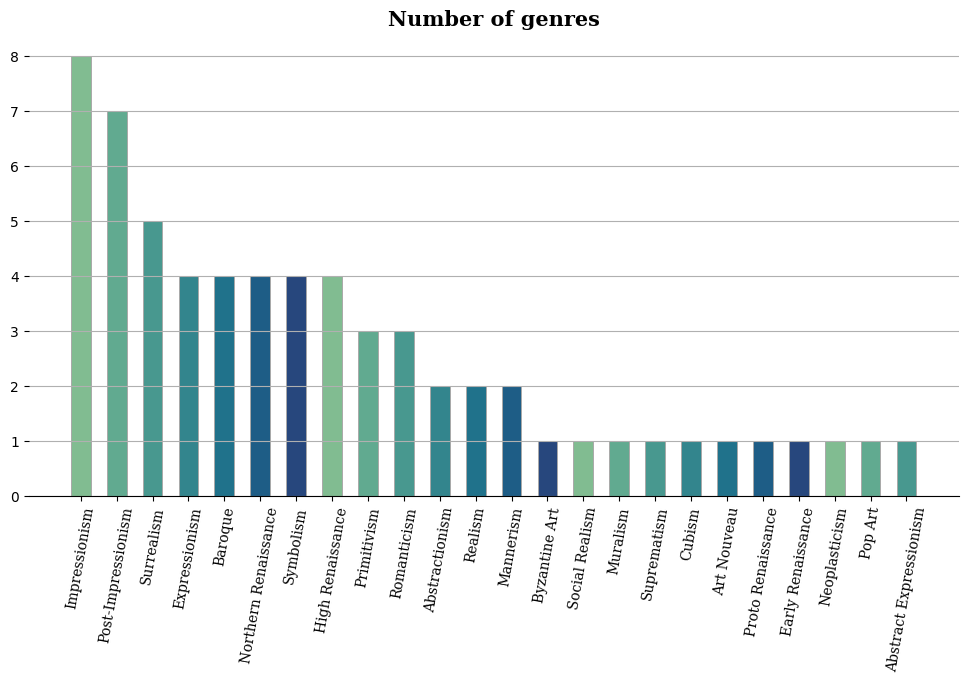

In [ ]:
# genre 컬럼의 쉼표로 구분된 장르를 하나씩 분리하여 카운트
all_genres = artist_info['genre'].str.split(',', expand=True).stack()

genre_counts = all_genres.value_counts()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.bar(genre_counts.index, genre_counts, width=0.55,
       edgecolor='darkgray', color=sns.color_palette('crest', 7),
       linewidth=0.7)

for genre in genre_counts.index:
    ax.annotate(f'{genre_counts[genre]}',
                xy=(genre, genre_counts[genre] + 10),
                va='center', ha='center', fontweight='light', fontfamily='serif',
                fontsize=7, color='#4a4a4a')

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.set_xticklabels(genre_counts.index, fontfamily='serif', rotation=80)
plt.title('Number of genres', fontsize=15, fontweight='bold', fontfamily='serif')
ax.grid(axis='y', linestyle='-')

plt.show()

In [ ]:
genre_counts

,count
Impressionism,8
Post-Impressionism,7
Surrealism,5
Expressionism,4
Baroque,4
Northern Renaissance,4
Symbolism,4
High Renaissance,4
Primitivism,3
Romanticism,3


- Post-Impressionism(탈인상주의)와 Impressionism(인상주의)의 그림이 많음
- 이름이 겹치는 장르가 있지만 이론적으론 다른 장르로 판단

In [ ]:
batch_size = 64
img_height = 600
img_width = 600
input_shape = (img_height, img_width)
n_classes = 50
classes = ['Diego_Velazquez', 'Vincent_van_Gogh', 'Claude_Monet',
       'Edgar_Degas', 'Hieronymus_Bosch', 'Pierre_Auguste_Renoir',
       'Rene_Magritte', 'Michelangelo', 'Peter_Paul_Rubens', 'Caravaggio',
       'Alfred_Sisley', 'Edouard_Manet', 'Rembrandt', 'Francisco_Goya',
       'Pablo_Picasso', 'Titian', 'Mikhail_Vrubel', 'Leonardo_da_Vinci',
       'Kazimir_Malevich', 'Andy_Warhol', 'Vasiliy_Kandinskiy',
       'Gustav_Klimt', 'Amedeo_Modigliani', 'Henri_Rousseau',
       'Salvador_Dali', 'Pieter_Bruegel', 'Albrecht_Du_rer',
       'Paul_Gauguin', 'Sandro_Botticelli', 'Piet_Mondrian',
       'Eugene_Delacroix', 'Paul_Klee', 'William_Turner', 'Marc_Chagall',
       'Jan_van_Eyck', 'Henri_Matisse', 'El_Greco', 'Gustave_Courbet',
       'Andrei_Rublev', 'Jackson_Pollock', 'Edvard_Munch',
       'Camille_Pissarro', 'Raphael', 'Henri_de_Toulouse_Lautrec',
       'Joan_Miro', 'Giotto_di_Bondone', 'Diego_Rivera', 'Frida_Kahlo',
       'Georges_Seurat', 'Paul_Cezanne']

#Image data generate with validation data fraction of 0.2 and data rescale 1/255.
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                                   rotation_range=20, width_shift_range =0.2,
                                   height_shift_range=0.2, shear_range=0.2,
                                   zoom_range=0.2, horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen= ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory='/content/content/drive/MyDrive/artist/train',
                                                    class_mode='categorical',
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,

                                                   )

valid_generator = train_datagen.flow_from_directory(directory='/content/content/drive/MyDrive/artist/train',
                                                    class_mode='categorical',
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=False,

                                                   )


STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 4749 images belonging to 50 classes.
Found 1161 images belonging to 50 classes.
Total number of batches = 74 and 18


In [ ]:
#test
#반복해서 돌리지않기
test_df['img_path'] = test_df['img_path'].str.replace("./", "/content/content/drive/MyDrive/artist/")

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  directory=None,
                                                  class_mode = None,
                                                  x_col = 'img_path',
                                                  y_col = None,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  seed=0)

STEP_SIZE_test = test_generator.n//test_generator.batch_size
print("Total number of batches =", STEP_SIZE_test, "and", STEP_SIZE_test)

Found 12670 validated image filenames.
Total number of batches = 197 and 197


In [ ]:
image, label = next(iter(train_generator))
image.shape, label.shape

((64, 600, 600, 3), (64, 50))

In [ ]:
import wandb
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold
from timm import create_model
from torch.cuda.amp import GradScaler
from tqdm import tqdm

In [ ]:
sample_data = next(iter(train_generator))
print("Sample image shape:", sample_data[0].shape)
print("Sample label shape:", sample_data[1].shape)

Sample image shape: (64, 600, 600, 3)
Sample label shape: (64, 50)


# ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.saving import register_keras_serializable
import pickle
import os

#drive.mount('/content/drive')
# Residual Block
@register_keras_serializable()  # 로딩
class ResidualBlock(Model):
    def __init__(self, num_kernels, kernel_size, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size

        self.conv1 = layers.Conv2D(num_kernels, kernel_size=kernel_size, padding="same", activation="relu")
        self.conv2 = layers.Conv2D(num_kernels, kernel_size=kernel_size, padding="same", activation="relu")
        self.add = layers.Add()
        self.relu = layers.Activation("relu")
        self.projection = None

    def build(self, input_shape):
        input_channels = input_shape[-1]
        if input_channels != self.num_kernels:
            self.projection = layers.Conv2D(self.num_kernels, kernel_size=(1, 1), padding="same")
        else:
            self.projection = lambda x: x

    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        shortcut = self.projection(input_tensor)
        x = self.add([x, shortcut])
        return self.relu(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_kernels": self.num_kernels,
            "kernel_size": self.kernel_size,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# ResNet 모델
input_shape = (600, 600, 3)  # 원하는 이미지 크기 (600x600)
num_classes = 50  # 예시로 50개의 클래스
n_epoch = 40  # 학습할 에폭 수

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = ResidualBlock(128, (3, 3))(x)
x = ResidualBlock(128, (3, 3))(x)
x = ResidualBlock(128, (3, 3))(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping 설정
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 데이터 제너레이터 (train_generator와 valid_generator는 이미 정의된 상태라고 가정)
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    epochs=n_epoch,
    callbacks=[early_stop]
)

# 모델 저장 경로 설정
model_dir = '/content/drive/MyDrive/artist_model'
os.makedirs(model_dir, exist_ok=True)

# 모델 저장
model.save(os.path.join(model_dir, 'my_model.keras'))

# history 저장
with open(os.path.join(model_dir, 'history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

# 최종 훈련 정확도 출력
print(f"Training complete with final accuracy: {history.history['accuracy'][-1]:.4f}")
print("History keys:", history.history.keys())
print("Final training history:", history.history)

# CUDA

In [ ]:
epochs = 40
run_id = "run_001"  # Example, replace with dynamic naming

# Assuming `train_df`, `test_df` are already loaded
# train_df = pd.read_csv('./data/train.csv') # Load your training dataframe
# test_df = pd.read_csv('./data/test.csv') # Load your test dataframe

# Create Model
device = torch.device("cuda")
model = create_model('tf_efficientnet_b7_ns', pretrained=True, num_classes=n_classes)
model.to(device)
model = nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5, 6, 7, 8])  # Adjust based on your system

# Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Checkpoint saving
os.makedirs(f'./runs/{run_id}', exist_ok=True)
os.makedirs(f'./cms/', exist_ok=True)

# Initialize Wandb
wandb.init(project="236006", entity="auroraveil", name=run_id)
wandb.watch(model)

# Training Loop
for fold, (train_index, test_index) in enumerate(skf.split(np.zeros(len(t)), t)):
    data_train = train_df.loc[train_index]
    data_validation = train_df.loc[test_index]

    # Sampler for Weighted Random Sampling (class balance)
    class_counts = data_train['artist'].value_counts().to_dict()
    num_samples = sum(class_counts.values())
    class_weights = {l: round(num_samples / class_counts[l], 2) for l in class_counts.keys()}
    labels = data_train['artist'].to_list()

    weights = [class_weights[labels[i]] for i in range(int(num_samples))]
    sampler = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

    # Prepare DataLoader
    train_dataset = ARTDataset('train', './data', data_train, transform=transform_train)
    validation_dataset = ARTDataset('validation', './data', data_validation, transform=transform_train)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    validation_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    # Model training
    since = time.time()
    best_f1 = 0.0
    scaler = GradScaler()

    for epoch in range(epochs):
        print('-'*50)
        print(f'Epoch {epoch}/{epochs - 1}')
        train_loss = 0.0

        for phase in ['train', 'val']:
            running_loss = 0.0
            cm_preds = []
            cm_labels = []
            model_preds = []
            model_labels = []

            if phase == 'train':
                model.train()
            else:
                model.eval()

            for x, y in tqdm(iter(train_loader if phase == 'train' else validation_loader)):
                x = x.to(device)
                y = y.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast(enabled=True):
                        y_hat = model(x)
                        loss = criterion(y_hat, y)
                    _, preds = torch.max(y_hat, 1)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * x.size(0)
                model_labels += y.detach().cpu().numpy().tolist()
                model_preds += preds.detach().cpu().numpy().tolist()

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_f1 = f1_score(model_labels, model_preds, average='macro')
            print(f'[{phase}] Loss: {epoch_loss:.4f} Macro F1: {epoch_f1:.4f}')

            # Save checkpoint if improved
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                torch.save(model.state_dict(), f'./runs/{run_id}/best_model_fold{fold}.pt')
                confusion_mtx = confusion_matrix(model_labels, model_preds)
                plot_confusion_matrix(confusion_mtx, classes=class_counts.keys(), runid=run_id, epoch=epoch, f1=best_f1)

            # Log to wandb
            wandb.log({
                f'{phase}_loss': epoch_loss,
                f'{phase}_f1': epoch_f1
            })

    # Load the best model and test
    checkpoint = f'./runs/{run_id}/best_model_fold{fold}.pt'
    print(f'Loading checkpoint from: {checkpoint}')
    model.load_state_dict(torch.load(checkpoint))
    model.to(device)
    model.eval()

    # Inference
    test_preds = []
    with torch.no_grad():
        for x in tqdm(iter(test_loader)):
            batch_pred = model(x)
            _, pred = torch.max(batch_pred, 1)
            pred = pred.detach().cpu().numpy().tolist()
            test_preds.extend(pred)

    # Inverse transform for predictions
    test_preds = le.inverse_transform(test_preds)

    # Prepare submission
    sample_submission = pd.read_csv('./data/sample_submission.csv')
    sample_submission['artist'] = test_preds
    os.makedirs('./output/', exist_ok=True)
    sample_submission.to_csv(f'./output/{run_id}_fold{fold}.csv', index=False)

    # Finished fold
    print(f'Fold {fold} finished')

#YOLO

In [14]:
#프로젝트 클론
#!git clone https://github.com/ultralytics/ultralytics.git

 # 라이브러리 설치

!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.4/982.4 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [10]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [ ]:
%cd yolov5
!pip install -r requirements.txt

In [46]:
import random
import shutil

# 경로 설정
train_dir = '/content/drive/MyDrive/artist/train/resized'
val_dir = '/content/drive/MyDrive/artist/train/val'
train_size = 0.8  # 훈련 데이터 비율 (80%)

# 전체 이미지 파일 리스트 가져오기
all_images = []
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith('.jpg'):
            all_images.append(os.path.join(root, file))

# 훈련용, 검증용으로 나누기
random.shuffle(all_images)
train_images = all_images[:int(len(all_images) * train_size)]
val_images = all_images[int(len(all_images) * train_size):]

# val 디렉토리 생성 (존재하지 않으면)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

# 훈련용 이미지를 훈련 폴더에 그대로 두고, 검증용 이미지는 val 폴더로 이동
for image in val_images:
    shutil.move(image, os.path.join(val_dir, os.path.basename(image)))

In [48]:
# YAML 파일 내용
yaml_content = """
train: /content/drive/MyDrive/artist/train/resized
val: /content/drive/MyDrive/artist/train/val

nc: 50
names:
  0: 'Diego_Velazquez'
  1: 'Vincent_van_Gogh'
  2: 'Claude_Monet'
  3: 'Edgar_Degas'
  4: 'Hieronymus_Bosch'
  5: 'Pierre_Auguste_Renoir'
  6: 'Rene_Magritte'
  7: 'Michelangelo'
  8: 'Peter_Paul_Rubens'
  9: 'Caravaggio'
  10: 'Alfred_Sisley'
  11: 'Edouard_Manet'
  12: 'Rembrandt'
  13: 'Francisco_Goya'
  14: 'Pablo_Picasso'
  15: 'Titian'
  16: 'Mikhail_Vrubel'
  17: 'Leonardo_da_Vinci'
  18: 'Kazimir_Malevich'
  19: 'Andy_Warhol'
  20: 'Vasiliy_Kandinskiy'
  21: 'Gustav_Klimt'
  22: 'Amedeo_Modigliani'
  23: 'Henri_Rousseau'
  24: 'Salvador_Dali'
  25: 'Pieter_Bruegel'
  26: 'Albrecht_Du_rer'
  27: 'Paul_Gauguin'
  28: 'Sandro_Botticelli'
  29: 'Piet_Mondrian'
  30: 'Eugene_Delacroix'
  31: 'Paul_Klee'
  32: 'William_Turner'
  33: 'Marc_Chagall'
  34: 'Jan_van_Eyck'
  35: 'Henri_Matisse'
  36: 'El_Greco'
  37: 'Gustave_Courbet'
  38: 'Andrei_Rublev'
  39: 'Jackson_Pollock'
  40: 'Edvard_Munch'
  41: 'Camille_Pissarro'
  42: 'Raphael'
  43: 'Henri_de_Toulouse_Lautrec'
  44: 'Joan_Miro'
  45: 'Giotto_di_Bondone'
  46: 'Diego_Rivera'
  47: 'Frida_Kahlo'
  48: 'Georges_Seurat'
  49: 'Paul_Cezanne'
"""

# 'data.yaml' 파일을 지정된 경로에 생성
with open('/content/drive/MyDrive/artist/data.yaml', 'w') as file:
    file.write(yaml_content)

print("data.yaml 파일이 생성되었습니다.")


data.yaml 파일이 생성되었습니다.


In [49]:
import yaml
from IPython.display import Image, display, clear_output
data_yaml = '/content/drive/MyDrive/artist/data.yaml'
with open(data_yaml) as f:
  film = yaml.load(f, Loader=yaml.FullLoader)
  display(film)

{'train': '/content/drive/MyDrive/artist/train/resized',
 'val': '/content/drive/MyDrive/artist/train/val',
 'nc': 50,
 'names': {0: 'Diego_Velazquez',
  1: 'Vincent_van_Gogh',
  2: 'Claude_Monet',
  3: 'Edgar_Degas',
  4: 'Hieronymus_Bosch',
  5: 'Pierre_Auguste_Renoir',
  6: 'Rene_Magritte',
  7: 'Michelangelo',
  8: 'Peter_Paul_Rubens',
  9: 'Caravaggio',
  10: 'Alfred_Sisley',
  11: 'Edouard_Manet',
  12: 'Rembrandt',
  13: 'Francisco_Goya',
  14: 'Pablo_Picasso',
  15: 'Titian',
  16: 'Mikhail_Vrubel',
  17: 'Leonardo_da_Vinci',
  18: 'Kazimir_Malevich',
  19: 'Andy_Warhol',
  20: 'Vasiliy_Kandinskiy',
  21: 'Gustav_Klimt',
  22: 'Amedeo_Modigliani',
  23: 'Henri_Rousseau',
  24: 'Salvador_Dali',
  25: 'Pieter_Bruegel',
  26: 'Albrecht_Du_rer',
  27: 'Paul_Gauguin',
  28: 'Sandro_Botticelli',
  29: 'Piet_Mondrian',
  30: 'Eugene_Delacroix',
  31: 'Paul_Klee',
  32: 'William_Turner',
  33: 'Marc_Chagall',
  34: 'Jan_van_Eyck',
  35: 'Henri_Matisse',
  36: 'El_Greco',
  37: 'Gustave

In [35]:
train_df[:20]

,id,img_path,artist,labels
0,0,/content/drive/MyDrive/artist/train/0000.jpg,Diego_Velazquez,9
1,1,/content/drive/MyDrive/artist/train/0001.jpg,Vincent_van_Gogh,48
2,2,/content/drive/MyDrive/artist/train/0002.jpg,Claude_Monet,7
3,3,/content/drive/MyDrive/artist/train/0003.jpg,Edgar_Degas,10
4,4,/content/drive/MyDrive/artist/train/0004.jpg,Hieronymus_Bosch,24
5,5,/content/drive/MyDrive/artist/train/0005.jpg,Pierre_Auguste_Renoir,38
6,6,/content/drive/MyDrive/artist/train/0006.jpg,Rene_Magritte,43
7,7,/content/drive/MyDrive/artist/train/0007.jpg,Rene_Magritte,43
8,8,/content/drive/MyDrive/artist/train/0008.jpg,Michelangelo,31
9,9,/content/drive/MyDrive/artist/train/0009.jpg,Peter_Paul_Rubens,37


In [18]:
train_df['img_path'] = train_df['img_path'].str.replace("./", "/content/drive/MyDrive/artist/")

In [20]:
test_df['img_path'] = test_df['img_path'].str.replace("./", "/content/drive/MyDrive/artist/")

In [29]:
import os
import cv2
import pandas as pd

# 이미지 폴더 경로
image_dir = '/content/drive/MyDrive/artist/train'
# 라벨 파일을 저장할 디렉토리 경로
label_dir = '/content/drive/MyDrive/artist/label'


# 클래스 이름과 ID (라벨) - 예시로 train_df에서 직접 클래스 인덱스를 매핑합니다.
classes = {name: index for index, name in enumerate(train_df['artist'].unique())}

# 이미지 리사이징 및 라벨 변환 함수
def resize_and_create_label(image_id):
    # 이미지 파일 경로
    image_file = f"{image_id:04d}.jpg"
    img_path = os.path.join(image_dir, image_file)

    # 파일이 실제로 존재하는지 확인
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return None

    # 이미지 로드
    img = cv2.imread(img_path)

    # 이미지가 로드되지 않으면 오류 메시지를 출력하고 건너뜁니다.
    if img is None:
        print(f"Error loading image: {img_path}")
        return None

    # 원본 이미지 크기
    h, w, _ = img.shape

    # 이미지 리사이징
    resized_img = cv2.resize(img, (600, 600))

    # 해당 이미지의 artist 찾기
    artist_name = train_df.loc[train_df['id'] == image_id, 'artist'].values[0]
    class_id = classes.get(artist_name)  # 클래스 인덱스 가져오기

    if class_id is None:
        print(f"Artist not found: {artist_name}")
        return None

    # YOLO 형식에 맞게 바운딩 박스 예시 (여기서는 임시로 중앙에 0.5 크기의 바운딩 박스를 사용)
    x_center = 0.5
    y_center = 0.5
    width = 1.0
    height = 1.0

    # YOLO 라벨 포맷으로 작성
    yolo_label = f"{class_id} {x_center} {y_center} {width} {height}"

    # 리사이즈된 이미지 저장
    resized_img_path = os.path.join(image_dir, "resized", image_file)
    os.makedirs(os.path.dirname(resized_img_path), exist_ok=True)
    cv2.imwrite(resized_img_path, resized_img)

    # YOLO 라벨 저장
    label_output_path = os.path.join(label_dir, f"{image_id}.txt")
    os.makedirs(os.path.dirname(label_output_path), exist_ok=True)
    with open(label_output_path, 'w') as label_file:
        label_file.write(yolo_label)

    return resized_img_path, label_output_path

# 전체 이미지 처리 (train_df에 있는 id에 해당하는 이미지에 대해서 처리)
for image_id in train_df['id']:
    resize_and_create_label(image_id)


Image not found: /content/drive/MyDrive/artist/train/0.jpg
Image not found: /content/drive/MyDrive/artist/train/1.jpg
Image not found: /content/drive/MyDrive/artist/train/2.jpg
Image not found: /content/drive/MyDrive/artist/train/3.jpg
Image not found: /content/drive/MyDrive/artist/train/4.jpg
Image not found: /content/drive/MyDrive/artist/train/5.jpg
Image not found: /content/drive/MyDrive/artist/train/6.jpg
Image not found: /content/drive/MyDrive/artist/train/7.jpg
Image not found: /content/drive/MyDrive/artist/train/8.jpg
Image not found: /content/drive/MyDrive/artist/train/9.jpg
Image not found: /content/drive/MyDrive/artist/train/10.jpg
Image not found: /content/drive/MyDrive/artist/train/11.jpg
Image not found: /content/drive/MyDrive/artist/train/12.jpg
Image not found: /content/drive/MyDrive/artist/train/13.jpg
Image not found: /content/drive/MyDrive/artist/train/14.jpg
Image not found: /content/drive/MyDrive/artist/train/15.jpg
Image not found: /content/drive/MyDrive/artist/tra

In [30]:
'''
# 클래스 인덱스를 딕셔너리로 매핑 (artist 이름을 인덱스로)
class_map = {name: idx for idx, name in enumerate(classes)}

# 이미지 리사이징 및 라벨 변환 함수
def resize_and_create_label(image_id):
    # 이미지 파일 경로 (id가 1일 때 '0001.jpg', id가 2일 때 '0002.jpg'로 파일명이 되어 있다고 가정)
    image_file = f"{image_id:04d}.jpg"  # 예: '0001.jpg'
    img_path = os.path.join(image_dir, image_file)

    # 파일이 실제로 존재하는지 확인
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return None

    # 이미지 로드
    img = cv2.imread(img_path)

    # 이미지가 로드되지 않으면 오류 메시지를 출력하고 건너뜁니다.
    if img is None:
        print(f"Error loading image: {img_path}")
        return None

    # 원본 이미지 크기
    h, w, _ = img.shape

    # 이미지 리사이징
    resized_img = cv2.resize(img, (600, 600))

    # 해당 이미지의 artist 찾기
    artist_name = train_df.loc[train_df['id'] == image_id, 'artist'].values[0]
    class_id = class_map.get(artist_name)  # 클래스 인덱스 가져오기

    if class_id is None:
        print(f"Artist not found: {artist_name}")
        return None

    # YOLO 형식에 맞게 바운딩 박스 예시 (여기서는 임시로 중앙에 0.5 크기의 바운딩 박스를 사용)
    x_center = 0.5
    y_center = 0.5
    width = 1.0
    height = 1.0

    # YOLO 라벨 포맷으로 작성
    yolo_label = f"{class_id} {x_center} {y_center} {width} {height}"

    # 리사이즈된 이미지 저장
    resized_img_path = os.path.join(image_dir, "resized", image_file)
    os.makedirs(os.path.dirname(resized_img_path), exist_ok=True)
    cv2.imwrite(resized_img_path, resized_img)

    # YOLO 라벨 저장
    label_output_path = os.path.join(label_dir, f"{image_id:04d}.txt")
    os.makedirs(os.path.dirname(label_output_path), exist_ok=True)
    with open(label_output_path, 'w') as label_file:
        label_file.write(yolo_label)

    return resized_img_path, label_output_path

# 전체 이미지 처리 (train_df에 있는 id에 해당하는 이미지에 대해서 처리)
for image_id in range(1000):  # 0000.jpg부터 0999.jpg까지
    resize_and_create_label(image_id)
    '''

In [47]:
#!rm -rf /content/drive/MyDrive/artist/data.yaml

In [ ]:
#train_df = train_df[train_df['id'] != 3732]

In [53]:
# 경로 설정
label_dir = '/content/drive/MyDrive/artist/train/label'
resized_dir = '/content/drive/MyDrive/artist/train/resized'

# label 폴더 내 모든 .txt 파일을 resized 폴더로 복사
for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
        # .txt 파일 경로
        label_file_path = os.path.join(label_dir, label_file)

        # 해당 이미지 이름에 해당하는 이미지 파일 경로 생성
        image_file = label_file.replace('.txt', '.jpg')
        image_file_path = os.path.join(resized_dir, image_file)

        # .txt 파일이 존재하는 경우, resized 폴더에 복사
        if os.path.exists(image_file_path):
            # 복사할 경로
            shutil.copy(label_file_path, resized_dir)
            print(f"Copied {label_file} to {resized_dir}")
        else:
            print(f"Image not found for {label_file}, skipping.")

print("파일 복사 완료!")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Image not found for 1911.txt, skipping.
Copied 1912.txt to /content/drive/MyDrive/artist/train/resized
Copied 1913.txt to /content/drive/MyDrive/artist/train/resized
Image not found for 1914.txt, skipping.
Image not found for 1915.txt, skipping.
Image not found for 1916.txt, skipping.
Copied 1917.txt to /content/drive/MyDrive/artist/train/resized
Copied 1918.txt to /content/drive/MyDrive/artist/train/resized
Copied 1919.txt to /content/drive/MyDrive/artist/train/resized
Copied 1920.txt to /content/drive/MyDrive/artist/train/resized
Copied 1921.txt to /content/drive/MyDrive/artist/train/resized
Copied 1922.txt to /content/drive/MyDrive/artist/train/resized
Copied 1923.txt to /content/drive/MyDrive/artist/train/resized
Image not found for 1924.txt, skipping.
Copied 1925.txt to /content/drive/MyDrive/artist/train/resized
Copied 1926.txt to /content/drive/MyDrive/artist/train/resized
Image not found for 1927.txt, skipping.
Copied 1928.txt to /content/dri

In [54]:
# 경로 설정
label_dir = '/content/drive/MyDrive/artist/train/label'
resized_dir = '/content/drive/MyDrive/artist/train/val'

# label 폴더 내 모든 .txt 파일을 resized 폴더로 복사
for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
        # .txt 파일 경로
        label_file_path = os.path.join(label_dir, label_file)

        # 해당 이미지 이름에 해당하는 이미지 파일 경로 생성
        image_file = label_file.replace('.txt', '.jpg')
        image_file_path = os.path.join(resized_dir, image_file)

        # .txt 파일이 존재하는 경우, resized 폴더에 복사
        if os.path.exists(image_file_path):
            # 복사할 경로
            shutil.copy(label_file_path, resized_dir)
            print(f"Copied {label_file} to {resized_dir}")
        else:
            print(f"Image not found for {label_file}, skipping.")

print("파일 복사 완료!")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Copied 1911.txt to /content/drive/MyDrive/artist/train/val
Image not found for 1912.txt, skipping.
Image not found for 1913.txt, skipping.
Copied 1914.txt to /content/drive/MyDrive/artist/train/val
Copied 1915.txt to /content/drive/MyDrive/artist/train/val
Copied 1916.txt to /content/drive/MyDrive/artist/train/val
Image not found for 1917.txt, skipping.
Image not found for 1918.txt, skipping.
Image not found for 1919.txt, skipping.
Image not found for 1920.txt, skipping.
Image not found for 1921.txt, skipping.
Image not found for 1922.txt, skipping.
Image not found for 1923.txt, skipping.
Copied 1924.txt to /content/drive/MyDrive/artist/train/val
Image not found for 1925.txt, skipping.
Image not found for 1926.txt, skipping.
Copied 1927.txt to /content/drive/MyDrive/artist/train/val
Image not found for 1928.txt, skipping.
Image not found for 1929.txt, skipping.
Image not found for 1930.txt, skipping.
Image not found for 1931.txt, skipping.
Image not 

In [59]:
import os
cache_path = "/content/drive/MyDrive/artist/train/resized.cache"
if os.path.exists(cache_path):
    os.remove(cache_path)

In [ ]:
!python train.py --img 600 --batch 16 --epochs 50 --data /content/drive/MyDrive/artist/data.yaml --weight yolov5s.pt --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-04-22 10:40:45.332889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745318445.576234   31285 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745318445.641414   31285 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ossory (ossory526) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=/conten

In [ ]:
!mv /content/yolov5 /content/drive/MyDrive/